# Finding neighbouring vertices in a mesh

In [1]:
import nibabel as nib
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

# Load the standard surface mesh
mesh_file_path = '/home/ln275/f_mc1689_1/AnalysisTools/ActflowToolbox/dependencies/ColeAnticevicNetPartition/'
projdir = '/home/ln275/f_mc1689_1/multitask_generalization/'
helpfiles_dir = projdir + 'docs/experimentfiles/'
derivatives_dir = projdir + 'data/derivatives/surface/'

def get_faces_coords_cortical_indices(hemisphere='R'):
    
    mesh_file = mesh_file_path + 'S1200.'+ hemisphere +'.midthickness_MSMAll.32k_fs_LR.surf.gii'
    surf_img = nib.load(mesh_file)

    # Get the coordinates (vertices) and faces (triangles)
    coords = surf_img.agg_data('pointset')
    faces = surf_img.agg_data('triangle')

    # Load the atlas ROI file that defines the medial wall exclusion
    # This file is typically named something like "R.atlasroi.32k_fs_LR.shape.gii"
    # and is available in the HCP standard_mesh_atlases directory
    roi_file = helpfiles_dir + hemisphere + '.atlasroi.32k_fs_LR.shape.gii'
    roi_img = nib.load(roi_file)
    roi_data = roi_img.agg_data()

    # Create a mask of non-medial wall vertices (1 = cortex, 0 = medial wall)
    cortex_mask = roi_data > 0

    # Get the indices of cortical vertices (excluding medial wall)
    cortical_indices = np.where(cortex_mask)[0]
    
    return faces, coords, cortical_indices

In [2]:
_, _, cortical_indices_L = get_faces_coords_cortical_indices(hemisphere='L')
_, _, cortical_indices_R = get_faces_coords_cortical_indices(hemisphere='R')
print('left hemisphere vertices:',len(cortical_indices_L))
print('right hemisphere vertices:',len(cortical_indices_R))

left hemisphere vertices: 29696
right hemisphere vertices: 29716


In [2]:
# Function to find neighbors for a given vertex index
def get_vertex_neighbors_with_distances(faces, coords, vertex_index, cortical_indices=None, max_neighbors=6):
    """Find neighbors of a given vertex in a triangular mesh and calculate distances.
    
    Args:
        faces: Array of triangle faces, shape (n_faces, 3)
        coords: Array of vertex coordinates, shape (n_vertices, 3)
        vertex_index: Index of the vertex to find neighbors for
        cortical_indices: Indices of vertices that are part of the cortex (excluding medial wall)
        max_neighbors: Maximum number of neighbors to return
        
    Returns:
        tuple: (neighbor_indices, distances)
    """
    # Find all faces containing this vertex
    containing_faces = []
    for i, face in enumerate(faces):
        if vertex_index in face:
            containing_faces.append(i)
    
    # Get all unique vertices in these faces
    neighbors = set()
    for face_idx in containing_faces:
        face = faces[face_idx]
        for v in face:
            if v != vertex_index:
                neighbors.add(v)
    
    # If we have cortical indices, filter neighbors to only include cortical vertices
    if cortical_indices is not None:
        cortical_set = set(cortical_indices)
        neighbors = neighbors.intersection(cortical_set)
    
    # Calculate distances to each neighbor
    neighbor_list = list(neighbors)
    distances = []
    
    # Get the coordinates of the source vertex
    source_coords = coords[vertex_index]
    
    for neighbor in neighbor_list:
        # Get the coordinates of the neighbor vertex
        neighbor_coords = coords[neighbor]
        
        # Calculate Euclidean distance (works for neighboring vertices as geodesic approximation)
        dist = np.sqrt(np.sum((source_coords - neighbor_coords)**2))
        distances.append(dist)
    
    # Sort by distance if needed and limit to max_neighbors
    if len(neighbor_list) > max_neighbors:
        sorted_indices = np.argsort(distances)
        neighbor_list = [neighbor_list[i] for i in sorted_indices[:max_neighbors]]
        distances = [distances[i] for i in sorted_indices[:max_neighbors]]
    
    return neighbor_list, distances

# # Example usage for a cortical vertex (ensure the vertex is in the cortical mask)
# # First choose a vertex that is known to be in the cortex
# test_vertex = cortical_indices[1000]  # Just an example, pick a vertex from cortical indices
# neighbors, distances = get_vertex_neighbors_with_distances(faces, coords, test_vertex, cortical_indices)

In [3]:
def process_vertex(vertidx, faces, coords, cortical_indices):
    """Process a single vertex and return its index and mean distance to neighbors"""
    neighbors, distances = get_vertex_neighbors_with_distances(faces, coords, vertidx, cortical_indices)
    return vertidx, np.mean(distances)

def parallel_process_vertices_joblib(faces, coords, cortical_indices, n_jobs=-1):
    """Process all vertices in parallel using joblib"""
    # Use joblib's Parallel
    results = Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(process_vertex)(vertidx, faces, coords, cortical_indices) 
        for vertidx in range(len(cortical_indices))
    )
    
    # Extract results
    intervertex_dist = np.zeros(len(cortical_indices))
    for vertidx, mean_dist in results:
        intervertex_dist[vertidx] = mean_dist
    
    return intervertex_dist

In [4]:
# Left hemisphere
facesL, coordsL, cortical_indicesL = get_faces_coords_cortical_indices(hemisphere='L')

# Use the joblib parallel function
intervertex_distL = parallel_process_vertices_joblib(facesL, coordsL, cortical_indicesL)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/projects/f_mc1689_1/AnalysisTools/anaconda3b/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/f_mc1689_1/AnalysisTools/anaconda3b/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.6s
/projects/f_mc1689_1/AnalysisTools/anaconda3b/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/f_mc1689_1/AnalysisTools/anaconda3b/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/f_mc1689_1/AnalysisTools/anaconda3b/lib/python3.9/site-packages/numpy/

In [5]:
# Right hemisphere
facesR, coordsR, cortical_indicesR = get_faces_coords_cortical_indices(hemisphere='R')

# Use the joblib parallel function
intervertex_distR = parallel_process_vertices_joblib(facesR, coordsR, cortical_indicesR)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 11218 tasks      

In [7]:
import pickle

# Merge and save
intervertex_dist_LR = np.hstack((intervertex_distL,intervertex_distR))

with open(derivatives_dir + 'intervertex_dist_LR.pkl', 'wb') as f:
    pickle.dump(intervertex_dist_LR,f)

In [8]:
# Read back

with open(derivatives_dir + 'intervertex_dist_LR.pkl', 'rb') as f:
    intervertex_dist_LR = pickle.load(f)

In [9]:
intervertex_dist_LR.shape

(59412,)

(array([1.1600e+02, 8.9740e+03, 1.7165e+04, 1.9673e+04, 6.9580e+03,
        1.2160e+03, 1.4800e+02, 3.9000e+01, 1.3000e+01, 1.4000e+01]),
 array([0.52996671, 0.83772219, 1.14547768, 1.45323316, 1.76098864,
        2.06874412, 2.37649961, 2.68425509, 2.99201057, 3.29976605,
        3.60752153]),
 <BarContainer object of 10 artists>)

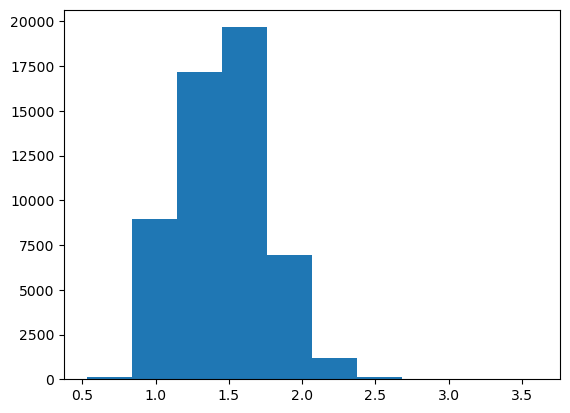

In [10]:
import matplotlib.pyplot as plt

plt.hist(intervertex_dist_LR)